#### Methodology to address fundamental problem 1 itemized in Issue 1024 - follow-up compare tabulations and relative household burden. This time I extend the 12-112 notebook to look at the revised methodology only.

### Indicator reviewed: 

Socioeconomic Factors Indicator reviewed
*  [Extreme Housing Burden](#housingburden)

#### Packages

In [3]:
import math
import numpy as np
import os
import pandas as pd
import requests
import zipfile
from pathlib import Path
import shutil

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from cenpy import products
%matplotlib inline

/Users/sarahluw/justice-40-main/justice40-tool/data/data-pipeline/justifce-40-main-env/lib/python3.7/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string
/Users/sarahluw/justice-40-main/justice40-tool/data/data-pipeline/justifce-40-main-env/lib/python3.7/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


### ETL process for acquiring relevant tables

#### NOTE: If you ran the ETL Process to acquire Table 8 in the other notebook of this draft PR you do not need to run the ETL cell block again

In [ ]:
# Copy and adapt certain sections of code from data_pipeline.utils 

def download_hud_dataset():
    DOWNLOAD_FILENAME = "HUD_ZIPPED.csv"
    HOUSING_FTP_URL = "https://www.huduser.gov/portal/datasets/cp/2014thru2018-140-csv.zip"    
    response = requests.get(HOUSING_FTP_URL, verify=True)
    if response.status_code == 200:
        file_contents = response.content
    else:
        sys.exit(
            f"HTTP response {response.status_code} from url {file_url}. Info: {response.content}"
        )

    # Write the contents to disk.
    file = open(DOWNLOAD_FILENAME, "wb")
    file.write(file_contents)
    file.close()
    
def extract_zipped_download(zip_file_path, unzipped_path):
    with zipfile.ZipFile(zip_file_path, "r") as zip_ref:
        zip_ref.extractall(unzipped_path)
    # cleanup temporary file
    os.remove(zip_file_path)
    
def up_one_directory(path):
    try:
        # from Python 3.6
        parent_dir = Path(path).parents[1]
        # for Python 3.4/3.5, use str to convert the path to string
        # parent_dir = str(Path(path).parents[1])
        shutil.move(path, parent_dir)
    except IndexError:
        # no upper directory
        pass

CURRENT_DIRECTORY = os.getcwd()
download_hud_dataset()
extract_zipped_download(CURRENT_DIRECTORY + "/HUD_ZIPPED.csv", CURRENT_DIRECTORY)  
up_one_directory(CURRENT_DIRECTORY + "/140/Table8.csv")
shutil.rmtree("./140/")

### Extreme Housing Burden <a id='housingburden'></a>

The Extreme Housing Burden indicator represents the proportion of low-income households that have to spend more than half their income on rent. These households experience higher levels of stress, report lower health, and may delay medical treatment because of its high cost.

The Extreme Housing Burden indicator measures the percent of households in a census tract that are:

1. Making less than 80% of the Area Median Family Income as determined by the Department of Housing and Urban Development (HUD), and
2. Paying greater than 50% of their income to housing costs. 

This data is sourced from the 2014-2018 Comprehensive Housing Affordability Strategy dataset from the Department of Housing and Urban Development (HUD) using the census tract geographic summary level, and contains cost burdens for households by percent HUD-adjusted median family income (HAMFI) category. This data can be found [here](https://www.huduser.gov/portal/datasets/cp.html). 

Because CHAS data is based on American Communities Survey (ACS) estimates, which come from a sample of the population, they may be unreliable if based on a small sample or population size.

The standard error and relative standard error were used to evaluate the reliability of each estimate using CalEnviroScreen’s methodology. 

Census tract estimates that met either of the following criteria were considered reliable and included in the analysis [(CalEnviroScreen, 2017, page 129)](https://oehha.ca.gov/media/downloads/calenviroscreen/report/ces3report.pdf ):

- Relative standard error less than 50 (meaning the standard error was less than half of the estimate), OR 
- Standard error less than the mean standard error of all census tract estimates 

Formulas for calculating the standard error of sums, proportions, and ratio come from the [American Communities Survey Office](https://www2.census.gov/programs-surveys/acs/tech_docs/accuracy/MultiyearACSAccuracyofData2013.pdf).

Note that this code creates a score and rank by state, for every state.

The relevant variables in table 8 of the CHAS dataset are the following (CHAS data dictionary available [here](https://www.huduser.gov/portal/datasets/cp/CHAS-data-dictionary-14-18.xlsx)):

|   Name  |                          Label                      |
|---------|-----------------------------------------------------|
|T1_est1  |                                   Total Occupied housing units                                      | 
|T8_est10 |            Owner occupied less than or equal to 30% of HAMFI cost burden greater than 50%           |
|T8_est23 |Owner occupied greater than 30% but less than or equal to 50% of HAMFI	cost burden greater than 50%|
|T8_est36 |Owner occupied	greater than 50% but less than or equal to 80% of HAMFI	cost burden greater than 50%|
|T8_est76 |           Renter occupied less than or equal to 30% of HAMFI cost burden greater than 50%           |
|T8_est89 |Renter occupied	greater than 30% but less than or equal to 50% of HAMFI	cost burden greater than 50%|
|T8_est102|Renter occupied	greater than 50% but less than or equal to 80% of HAMFI	cost burden greater than 50%|
 

### Below I also propose an alternate means for ranking census tracts
### These steps are outlined and commented below

In [ ]:
# Read in the data from https://www.huduser.gov/portal/datasets/cp.html
housing = pd.read_csv("Table8.csv", 
                      encoding = "ISO-8859-1",  
                      dtype = {'Tract_ID': object, 'st': object, 'geoid': object})

# Remove data for states that aren't included in the census (e.g. American Samoa, Guam, etc.):
housing.drop(housing.loc[housing['st'] == '72'].index, inplace = True)

# Combine owner and renter occupied low-income households that make less than 80% of HAMFI into one variable
housing['summed'] = (housing['T8_est10'] + 
                     housing['T8_est23'] + 
                     housing['T8_est36'] + 
                     housing['T8_est76'] + 
                     housing['T8_est89'] + 
                     housing['T8_est102'])

# Create a variable for the standard error of the summed variables
housing['summed_se'] = np.sqrt((housing['T8_moe10'] / 1.645)**2 + 
                                (housing['T8_moe23'] / 1.645)**2 + 
                                (housing['T8_moe36'] / 1.645)**2 + 
                                (housing['T8_moe76'] / 1.645)**2 + 
                                (housing['T8_moe89'] / 1.645)**2 + 
                                (housing['T8_moe102'] / 1.645)**2)

# Remove the first 7 digits in the FIPS Census Tract ID 
housing['geoid'] = housing['geoid'].str[-11:]

# Find the estimate of the proportion of the population that is heavily rent burdened
housing['hbrd_score'] = housing['summed'] / housing['T8_est1']

# Change rates where the population is 0 to nan
housing['hbrd_score'].replace(np.inf, np.nan, inplace = True)

# Create function for calculating the standard error, using the proportions standard error formula
#  if the value under the radical is negative, use the ratio standard error formula
def se_prop(x, y, se_x, moe_y): 
    se_y = moe_y / 1.645
    test = se_x**2 - (((x**2)/(y**2))*((se_y)**2))
    se = np.where(test < 0,
                   (1/y) * np.sqrt(se_x**2 + (((x**2)/(y**2))*(se_y**2))), 
                   (1/y) * np.sqrt(se_x**2 - (((x**2)/(y**2))*(se_y**2))))
    return se

housing['se'] = se_prop(housing['summed'], housing['T8_est1'], housing['summed_se'], housing['T8_moe1'])

# Calculate the relative standard error
housing['rse'] = housing['se'] / housing['hbrd_score']*100

# Change infinite rse's where the housing burden is 0 to np.nan
housing['rse'].replace(np.inf, np.nan, inplace = True)

# Calculate the mean standard error for each state
housing['mean_state_se'] = np.zeros(len(housing))

for state in housing['st'].unique():
    mean_se = np.mean(housing[housing['st'] == state]['se'])
    housing['mean_state_se'].loc[housing['st'] == state] = mean_se
    
# Find census tract estimates that meet both of the following criteria and are thus considered unreliable estimates: 
# RSE less than 50 AND
# SE less than the mean state SE or housing burdened low income households
# Convert these scores to nan
housing.loc[(housing['rse'] >= 50) & (housing['rse'] >= housing['mean_state_se']), 'hbrd_score'] = np.nan

# Rename columns
housing = housing.rename(columns = {'geoid' :'FIPS_tract_id',
                                    'st' : 'state'
                                   })

# Calculate percentile rank for census tracts with a score above 0, set percentile to 0 if score is 0, for each state
housing['hbrd_rank'] = housing[
            housing['hbrd_score'] != 0][['hbrd_score',
                'state']].groupby('state').rank( 
                na_option = 'keep', 
                pct = True) * 100

housing.loc[housing['hbrd_score'] == 0, 'hbrd_rank'] = 0

# Create final housing burden df
housingburden = housing.copy()

In [ ]:
housingburden.head()

In [ ]:
housingburden.shape

### As desired we see a uniform distribution for the percentile rank for burdened households

In [ ]:
plt.figure(figsize=(12, 8))
plt.title('Relative Housing Burden (Percentile rank) - CalEnvironScreen Methodology')
# Set x-axis label
plt.xlabel('Percentile Rank')
# Set y-axis label
plt.ylabel('Relative Frequency in Support')

sns.histplot(housingburden["hbrd_rank"])

### Now we compute for a baseline comparison 

In [ ]:
# Owner occupied numerator fields
OWNER_OCCUPIED_NUMERATOR_FIELDS = [
    # Column Name
    #   Line_Type
    #   Tenure
    #   Household income
    #   Cost burden
    #   Facilities
    "T8_est7",
    #   Subtotal
    #   Owner occupied
    #   less than or equal to 30% of HAMFI
    #   greater than 30% but less than or equal to 50%
    #   All
    "T8_est10",
    #   Subtotal
    #   Owner occupied
    #   less than or equal to 30% of HAMFI
    #   greater than 50%
    #   All
    "T8_est20",
    
    #   Subtotal
    #   Owner occupied
    #   greater than 30% but less than or equal to 50% of HAMFI
    #   greater than 30% but less than or equal to 50%
    #   All
    "T8_est23",
    #   Subtotal
    #   Owner occupied
    #   greater than 30% but less than or equal to 50% of HAMFI
    #   greater than 50%
    #   All
    "T8_est33",
    #   Subtotal
    #   Owner occupied
    #   greater than 50% but less than or equal to 80% of HAMFI
    #   greater than 30% but less than or equal to 50%
    #   All
    "T8_est36",
    #   Subtotal
    #   Owner occupied
    #   greater than 50% but less than or equal to 80% of HAMFI
    #   greater than 50%
    #   All
]

# These rows have the values where HAMFI was not computed, b/c of no or negative income.
OWNER_OCCUPIED_NOT_COMPUTED_FIELDS = [
    # Column Name
    #   Line_Type
    #   Tenure
    #   Household income
    #   Cost burden
    #   Facilities
    "T8_est13",
    #   Subtotal
    #   Owner occupied
    #   less than or equal to 30% of HAMFI
    #   not computed (no/negative income)
    #   All
    "T8_est26",
    #   Subtotal
    #   Owner occupied
    #   greater than 30% but less than or equal to 50% of HAMFI
    #   not computed (no/negative income)
    #   All
    "T8_est39",
    #   Subtotal
    #   Owner occupied
    #   greater than 50% but less than or equal to 80% of HAMFI
    #   not computed (no/negative income)
    #   All
    "T8_est52",
    #   Subtotal
    #   Owner occupied
    #   greater than 80% but less than or equal to 100% of HAMFI
    #   not computed (no/negative income)
    #   All
    "T8_est65",
    #   Subtotal
    #   Owner occupied
    #   greater than 100% of HAMFI
    #   not computed (no/negative income)
    #   All
]

OWNER_OCCUPIED_POPULATION_FIELD = "T8_est2"
#   Subtotal
#   Owner occupied
#   All
#   All
#   All

OWNER_OCCUPIED_POPULATION_HAMFI_FIELD = "T8_est3"
#   Subtotal
#   Owner occupied 
#   All
#   All
#   All

# Renter occupied numerator fields
RENTER_OCCUPIED_NUMERATOR_FIELDS = [
    # Column Name
    #   Line_Type
    #   Tenure
    #   Household income
    #   Cost burden
    #   Facilities
    "T8_est73",
    #   Subtotal
    #   Renter occupied
    #   less than or equal to 30% of HAMFI
    #   greater than 30% but less than or equal to 50%
    #   All
    "T8_est76",
    #   Subtotal
    #   Renter occupied
    #   less than or equal to 30% of HAMFI
    #   greater than 50%
    #   All
    "T8_est86",
    #   Subtotal
    #   Renter occupied
    #   greater than 30% but less than or equal to 50% of HAMFI
    #   greater than 30% but less than or equal to 50%
    #   All
    "T8_est89",
    #   Subtotal
    #   Renter occupied
    #   greater than 30% but less than or equal to 50% of HAMFI
    #   greater than 50%
    #   All
    "T8_est99",
    #   Subtotal
    #   Renter occupied	greater than 50% but less than or equal to 80% of HAMFI
    #   greater than 30% but less than or equal to 50%
    #   All
    "T8_est102",
    #   Subtotal
    #   Renter occupied
    #   greater than 50% but less than or equal to 80% of HAMFI
    #   greater than 50%
    #   All
]

# These rows have the values where HAMFI was not computed, b/c of no or negative income.
RENTER_OCCUPIED_NOT_COMPUTED_FIELDS = [
    # Column Name
    #   Line_Type
    #   Tenure
    #   Household income
    #   Cost burden
    #   Facilities
    "T8_est79",
    #   Subtotal
    #   Renter occupied	less than or equal to 30% of HAMFI
    #   not computed (no/negative income)
    #   All
    "T8_est92",
    #   Subtotal
    #   Renter occupied	greater than 30% but less than or equal to 50% of HAMFI
    #   not computed (no/negative income)
    #   All
    "T8_est105",
    #   Subtotal
    #   Renter occupied
    #   greater than 50% but less than or equal to 80% of HAMFI
    #   not computed (no/negative income)
    #   All
    "T8_est118",
    #   Subtotal
    #   Renter occupied	greater than 80% but less than or equal to 100% of HAMFI
    #   not computed (no/negative income)
    #   All
    "T8_est131",
    #   Subtotal
    #   Renter occupied
    #   greater than 100% of HAMFI
    #   not computed (no/negative income)
    #   All
]

# T8_est68	SubtotalRenter occupied	All	All	All
RENTER_OCCUPIED_POPULATION_FIELD = "T8_est68"

In [ ]:
housingburden["current_summed_methodology"] = housingburden[
    OWNER_OCCUPIED_NUMERATOR_FIELDS
].sum(axis=1) + housingburden[RENTER_OCCUPIED_NUMERATOR_FIELDS].sum(axis=1)

In [ ]:
housingburden["current_methodology_denominator"] = (
         housingburden[OWNER_OCCUPIED_POPULATION_FIELD]
            + housingburden[RENTER_OCCUPIED_POPULATION_FIELD]
            - housingburden[OWNER_OCCUPIED_NOT_COMPUTED_FIELDS].sum(axis=1)
            - housingburden[RENTER_OCCUPIED_NOT_COMPUTED_FIELDS].sum(axis=1)
)

In [ ]:
housingburden["current_methodology_denominator_sans_not_computed"] = (
         housingburden[OWNER_OCCUPIED_POPULATION_FIELD]
            + housingburden[RENTER_OCCUPIED_POPULATION_FIELD]
)

In [ ]:
housingburden["current_methodology_percent"] = np.round(
    (housingburden["current_summed_methodology"] / housingburden["current_methodology_denominator"] ), 2) * 100

In [ ]:
housingburden["absolute_difference"] = housingburden[
    "current_summed_methodology"] - housingburden["summed"]

In [ ]:
housingburden.to_csv("housing_burden_percentiles_12122021.csv", index=False)

### Now we construct the distribution of differences in the number of owned and rented burdened households


In [ ]:

plt.figure(figsize=(12, 8))
plt.title('Distribution of differences between two methodologies')
# Set x-axis label
plt.xlabel('Aggregate total owner and renter occupied low-income households < 80%')
# Set y-axis label
plt.ylabel('Relative Frequency in Support')

sns.histplot(housingburden["absolute_difference"])

### Plotting both distributions for accounting for different aggregations of owned and rented burdened households. Red is the revised version; green is the current methodology

In [ ]:
sns.set_color_codes()
plt.figure(figsize=(12, 8))
plt.title('Owner and renter occupied low-income households that make less than 80% of HAMF')
# Set y-axis label
plt.ylabel('Kernel density estimate')

sns.distplot(housingburden["current_summed_methodology"], 
      rug_kws={"color": "green"}, rug = True, 
          kde_kws={"color": "g", "lw": 3, "label": "KDE"},
          hist_kws={"histtype": "step", "linewidth": 3,
                    "alpha": 1, "color": "green"}
            )
sns.distplot(housingburden["summed"], 
          rug_kws={"color": "red"}, rug = True, 
          kde_kws={"color": "r", "lw": 3, "label": "KDE"},
          hist_kws={"histtype": "step", "linewidth": 3,
                    "alpha": 1, "color": "red"}
            )

plt.xlabel('Aggregate total owner and renter occupied low-income households < 80%')


## Now let's focus on West Virginia (FIPS code 54) and perform a nonparametric test to validate that the distributions are different for the health burden across all census tracts within West Virginia


Permutation sampling is a method to simulate the hypothesis that two variables have identical probability distributions. We perform this below. The red ECDF is the current tabulation of burdened household. The blue the proposed methodology for tabulation.

In [ ]:
def permutation_sample(data1, data2):
    """Generate a permutation sample from two data sets."""

    # Concatenate the data sets: data
    data = np.concatenate((data1, data2))

    # Permute the concatenated array: permuted_data
    permuted_data = np.random.permutation(data)

    # Split the permuted array into two: perm_sample_1, perm_sample_2
    perm_sample_1 = permuted_data[:len(data1)]
    perm_sample_2 = permuted_data[len(data1):]

    return perm_sample_1, perm_sample_2

def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n

    return x, y


current_methodology = housingburden[housingburden["state"] == '54']["current_summed_methodology"].values
revised_methodology = housingburden[housingburden["state"] == '54']["summed"].values

for _ in range(100):
    # Generate permutation samples
    perm_sample_1, perm_sample_2 = permutation_sample(current_methodology, revised_methodology)


    # Compute ECDFs
    x_1, y_1 = ecdf(perm_sample_1)
    x_2, y_2 = ecdf(perm_sample_2)

    # Plot ECDFs of permutation sample
    _ = plt.plot(x_1, y_1, marker='.', linestyle='none',
                 color='red', alpha=0.02)
    _ = plt.plot(x_2, y_2, marker='.', linestyle='none',
                 color='blue', alpha=0.02)

# Create and plot ECDFs from original data
x_1, y_1 = ecdf(current_methodology)
x_2, y_2 = ecdf(revised_methodology)
_ = plt.plot(x_1, y_1, marker='.', linestyle='none', color='red')
_ = plt.plot(x_2, y_2, marker='.', linestyle='none', color='blue')

# Label axes, set margin, and show plot
plt.margins(0.02)
_ = plt.xlabel('Total number of owner and rental burdened households using both methodologies')
_ = plt.ylabel('ECDF')
plt.show()

Notice that the permutation samples ECDFs overlap and give a purple haze. None of the ECDFs from the permutation samples overlap with the observed data, suggesting that the hypothesis is not commensurate with the data. Both methodologies for housing burden are not identically distributed.



## Nonparametric two-sample bootstrap test for sample mean

We now want to test the hypothesis that both methodologies have the same average housing burden across all census tracts in West Virginia, but not necessarily the same distribution, which is also impossible with a permutation test.

To do the two-sample bootstrap test, we shift both arrays to have the same mean, since we are simulating the hypothesis that their means are, in fact, equal. We then draw bootstrap samples out of the shifted arrays and compute the difference in means. This constitutes a bootstrap replicate, and we generate many of them. The p-value is the fraction of replicates with a difference in means greater than or equal to what was observed.

**Conclusion**:

We actually have evidence that the means are equal and corroborate a similar result as when we performed in the permutation test. Nonetheless, remember that it is important to carefully think about what question we want to ask. Are we only interested in the mean housing burden, or in the distribution of housing burdens across a state's census tract??

In [ ]:
def bootstrap_replicate_1d(data, func):
    """Generate bootstrap replicate of one dimensional data."""
    bs_sample = np.random.choice(data, len(data))
    return func(bs_sample)

def draw_bs_reps(data, func, size=1):
    """Draw bootstrap replicates."""
    # Initialize array of replicates
    bs_replicates = np.empty(size)
    # Generate replicates
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data, func)
    return bs_replicates

def diff_of_means(data_1, data_2):
    """Difference in means of two arrays."""

    # The difference of means of data_1, data_2: diff
    diff = np.mean(data_1) - np.mean(data_2)

    return diff

# Compute difference of mean burden from data
empirical_diff_means = diff_of_means(current_methodology, revised_methodology)

# Compute mean of all burdens (population)
mean_burden = np.mean(np.append(current_methodology, revised_methodology))

# Generate shifted arrays
burden_a_shifted = current_methodology - np.mean(current_methodology) + mean_burden
burden_b_shifted = revised_methodology - np.mean(revised_methodology) + mean_burden

# Compute 10,000 bootstrap replicates from shifted arrays
bs_replicates_a = draw_bs_reps(burden_a_shifted, np.mean, size=10000)
bs_replicates_b = draw_bs_reps(burden_b_shifted, np.mean, size=10000)

# Get replicates of difference of means
bs_replicates = bs_replicates_a - bs_replicates_b

# Compute and print p-value
p = np.sum(bs_replicates >= empirical_diff_means) / len(bs_replicates)
print("P Value: {:.4f}".format(round(p, 2)))

### Percentiles Comparison

In [ ]:
final_df = housingburden[['FIPS_tract_id', 'state','hbrd_rank','hbrd_score', 'summed', 
       'current_summed_methodology', 'T8_est1', 
        "current_methodology_denominator_sans_not_computed",
       'current_methodology_denominator',  'current_methodology_percent']]

##### First notice here that **T8_est1** and **current_methodology_denominator** should represent same or similar aggregates. In general, we cen see that the current computation performed results in a differerntial that undercounts the total occupied and rental households.

In [ ]:
final_df["differences_aggregate_denominator"] = (
    final_df["current_methodology_denominator"] - final_df["T8_est1"] 
)

In [ ]:
final_df["differences_aggregate_denominator_sans_not_computed"] = (
    final_df["current_methodology_denominator"] - final_df["T8_est1"] 
)

In [ ]:
plt.figure(figsize=(12, 8))
plt.title('Distribution of differences between aggregate totals that normalizes tabulation of poverty households')
# Set x-axis label
plt.xlabel('Aggregate differences in total owner and renter occupied low-income households < 80%')
# Set y-axis label
plt.ylabel('Relative Frequency in Support')

sns.histplot(final_df["differences_aggregate_denominator"])

In [ ]:
plt.figure(figsize=(12, 8))
plt.title('Distribution of differences between aggregate totals that normalizes tabulation of poverty households (with removal of not computed fields) ')
# Set x-axis label
plt.xlabel('Aggregate differences in total owner and renter occupied low-income households')
# Set y-axis label
plt.ylabel('Relative Frequency in Support')

sns.histplot(final_df["differences_aggregate_denominator_sans_not_computed"])

### Only include non-NA tracts for comparison purposes

In [ ]:
final_df = final_df[~final_df["hbrd_rank"].isna()]

In [ ]:
common_percentile = 90

# (final_df['current_methodology_percent'] >= 90).value_counts()

final_df["current_threshold_exceeded"] = (final_df['current_methodology_percent'] >= 90)

In [ ]:
final_df["new_threshold_exceeded"] = (final_df['hbrd_rank'] >= 90)

In [ ]:
final_df["new_threshold_exceeded"].value_counts()

In [ ]:
final_df["current_threshold_exceeded"].value_counts()

In [ ]:
final_df["hbrd_rank"].sort_values(ascending=False)[:10]

In [ ]:
# find the corresponding tracts that are different between the two
final_df.loc[final_df[
    'current_threshold_exceeded'] != final_df['new_threshold_exceeded']].head()

In [ ]:
# final_df.to_csv("housing_burdencomparison_two_methods_12192021.csv", index=False)

# Read Final Dataframe for all tracts

In [5]:
final_df = pd.read_csv("housing_burdencomparison_two_methods_12192021.csv")

In [6]:
final_df.shape

(67813, 14)

In [8]:
# merge_global = census_acs_2019.merge(final_df, 
#                                 left_on = "GEOID10_TRACT", 
#                                 right_on = "FIPS_tract_id")

In [10]:
# merge_global_stats = merge_global.groupby(["state"]).agg({
#        'GEOID10_TRACT': 'nunique',
#        'Percent of individuals < 200% Federal Poverty Line': [np.median, 'nunique', np.std],
#        'Median value ($) of owner-occupied housing units': [np.median, 'nunique', np.std],
#        'Percent individuals age 25 or over with less than high school degree': [np.median, 'nunique', np.std],
#        'Percent enrollment in college or graduate school': [np.median, 'nunique', np.std],
# #        'Hispanic or Latino': [np.median, 'nunique'. np.std],
#        'Percent Black or African American alone': [np.median, 'nunique', np.std],
#        'Percent American Indian and Alaska Native alone': [np.median, 'nunique', np.std],
#        'Percent Non-Hispanic White': [np.median, 'nunique', np.std], 
#      'Linguistic isolation (percent)': [np.median, 'nunique', np.std],
# #        'Percent of tract that is HOLC Grade D': [np.median, 'nunique', np.std],
# #        'Current lack of health insurance among adults aged 18-64 years': [np.median, 'nunique', np.std],
#        'Median household income in the past 12 months': [np.median, 'nunique', np.std],
#        'Percent Hispanic or Latino': [np.median, 'nunique', np.std],
#       'hbrd_rank': [np.median, 'nunique', np.std],
#       'current_methodology_percent': [np.median, 'nunique', np.std],
#       'current_summed_methodology': [np.median, 'nunique', np.std, np.sum]

# }).reset_index()

In [11]:
# merge_global_stats.columns = [' '.join(col).strip() for
#                               col in merge_global_stats.columns.values]

In [12]:
# np.median(merge_global_stats["Percent Black or African American alone median"] * 100)

In [13]:
# select only those tracts that meet the new housing burden definition
final_df = final_df[final_df["new_threshold_exceeded"] == True]

In [14]:
final_df.shape

(6801, 14)

In [15]:
# california is number 1
final_df.state.value_counts()[:10]

6     781
48    466
36    466
12    399
42    305
17    299
39    276
26    257
37    203
34    196
Name: state, dtype: int64

In [16]:
census_acs_2019 = pd.read_csv("../data/dataset/census_acs_2019/usa.csv")

In [17]:
census_acs_2019.dtypes

GEOID10_TRACT                                                             int64
Unemployed civilians (percent)                                          float64
Linguistic isolation (percent)                                          float64
Median household income in the past 12 months                             int64
Percent of individuals < 100% Federal Poverty Line                      float64
Percent of individuals < 150% Federal Poverty Line                      float64
Percent of individuals < 200% Federal Poverty Line                      float64
Median value ($) of owner-occupied housing units                          int64
Percent individuals age 25 or over with less than high school degree    float64
Percent enrollment in college or graduate school                        float64
Black or African American alone                                           int64
American Indian and Alaska Native alone                                   int64
Asian alone                             

In [18]:
census_acs_2019["GEOID10_TRACT"].head()

0    1073001100
1    1073001400
2    1073002000
3    1073003802
4    1073004000
Name: GEOID10_TRACT, dtype: int64

In [19]:
final_df['FIPS_tract_id'] = final_df['FIPS_tract_id'].astype(np.int64)

In [20]:
final_df.dtypes

FIPS_tract_id                                            int64
state                                                    int64
hbrd_rank                                              float64
hbrd_score                                             float64
summed                                                   int64
current_summed_methodology                               int64
T8_est1                                                  int64
current_methodology_denominator_sans_not_computed        int64
current_methodology_denominator                          int64
current_methodology_percent                            float64
differences_aggregate_denominator                        int64
differences_aggregate_denominator_sans_not_computed      int64
current_threshold_exceeded                                bool
new_threshold_exceeded                                    bool
dtype: object

In [21]:
merge_1 = census_acs_2019.merge(final_df, 
                                left_on = "GEOID10_TRACT", 
                                right_on = "FIPS_tract_id")

In [22]:
merge_1.head()

,GEOID10_TRACT,Unemployed civilians (percent),Linguistic isolation (percent),Median household income in the past 12 months,Percent of individuals < 100% Federal Poverty Line,Percent of individuals < 150% Federal Poverty Line,Percent of individuals < 200% Federal Poverty Line,Median value ($) of owner-occupied housing units,Percent individuals age 25 or over with less than high school degree,Percent enrollment in college or graduate school,...,summed,current_summed_methodology,T8_est1,current_methodology_denominator_sans_not_computed,current_methodology_denominator,current_methodology_percent,differences_aggregate_denominator,differences_aggregate_denominator_sans_not_computed,current_threshold_exceeded,new_threshold_exceeded
0,1073002000,0.137549,0.019732,27159,0.513352,0.616172,0.727976,68400,0.233405,0.063934,...,360,620,1455,1455,1425,44.0,-30,-30,False,True
1,1073003802,0.103332,0.000000,38721,0.196560,0.340389,0.529012,64100,0.143187,0.083550,...,460,775,1925,1925,1885,41.0,-40,-40,False,True
2,1073004000,0.211483,0.044787,18525,0.405843,0.585077,0.707856,67300,0.170472,0.039753,...,375,665,1515,1515,1420,47.0,-95,-95,False,True
3,1073005101,0.092632,0.000000,15833,0.622069,0.833103,0.842069,51000,0.254545,0.090062,...,149,329,640,635,625,53.0,-15,-15,False,True
4,1073010302,0.152021,0.019872,20696,0.401938,0.511390,0.593873,71900,0.158696,0.063147,...,385,590,1510,1510,1410,42.0,-100,-100,False,True


In [23]:
merge_1.shape

(6801, 38)

In [24]:
cdc_places = pd.read_csv("../data/dataset/cdc_places/usa.csv")

In [25]:
cdc_le = pd.read_csv("../data/dataset/cdc_life_expectancy/usa.csv")

In [26]:
# all CDC datasets
temp_cdc = cdc_places.merge(cdc_le, on = "GEOID10_TRACT")

In [27]:
# Segregation
# holc = pd.read_csv("../data/dataset/mapping_inequality/usa.csv")

In [28]:
# urban--rural
geo_corr = pd.read_csv("../data/dataset/geocorr/usa.csv")

In [29]:
geo_corr.head()

,GEOID10_TRACT,population_in_rural_areas,population_in_urban_areas,perc_population_in_rural_areas,perc_population_in_urban_areas,Urban Heuristic Flag
0,1001020100,318.0,1594.0,0.166318,0.833682,1
1,1001020200,NaN,2170.0,NaN,1.000000,1
2,1001020300,NaN,3373.0,NaN,1.000000,1
3,1001020400,NaN,4386.0,NaN,1.000000,1
4,1001020500,4.0,10762.0,0.000372,0.999628,1


In [30]:
merge_2 = geo_corr.merge(temp_cdc, on="GEOID10_TRACT")

# merge_3 = merge_2.merge(geo_corr, on="GEOID10_TRACT")

In [31]:
combined_df = merge_2.merge(merge_1, on="GEOID10_TRACT")

In [32]:
combined_df.head()

,GEOID10_TRACT,population_in_rural_areas,population_in_urban_areas,perc_population_in_rural_areas,perc_population_in_urban_areas,Urban Heuristic Flag,All teeth lost among adults aged >=65 years,Arthritis among adults aged >=18 years,Binge drinking among adults aged >=18 years,Cancer (excluding skin cancer) among adults aged >=18 years,...,summed,current_summed_methodology,T8_est1,current_methodology_denominator_sans_not_computed,current_methodology_denominator,current_methodology_percent,differences_aggregate_denominator,differences_aggregate_denominator_sans_not_computed,current_threshold_exceeded,new_threshold_exceeded
0,1005950700,430.0,1297.0,0.248987,0.751013,1,28.2,40.7,10.5,8.7,...,144,218,615,615,607,36.0,-8,-8,False,True
1,1011952100,1434.0,NaN,1.000000,NaN,0,39.6,40.6,9.6,6.7,...,174,222,645,645,641,35.0,-4,-4,False,True
2,1015000200,NaN,3104.0,NaN,1.000000,1,23.9,34.7,12.2,7.1,...,285,475,1240,1245,1225,39.0,-15,-15,False,True
3,1015000300,NaN,2951.0,NaN,1.000000,1,33.3,37.5,10.5,6.4,...,280,488,1220,1215,1175,42.0,-45,-45,False,True
4,1015002101,294.0,3698.0,0.073647,0.926353,1,24.9,13.2,18.0,2.1,...,365,483,1005,1000,970,50.0,-35,-35,False,True


In [34]:
combined_df.columns

Index(['GEOID10_TRACT', 'population_in_rural_areas',
       'population_in_urban_areas', 'perc_population_in_rural_areas',
       'perc_population_in_urban_areas', 'Urban Heuristic Flag',
       'All teeth lost among adults aged >=65 years',
       'Arthritis among adults aged >=18 years',
       'Binge drinking among adults aged >=18 years',
       'Cancer (excluding skin cancer) among adults aged >=18 years',
       'Cervical cancer screening among adult women aged 21-65 years',
       'Cholesterol screening among adults aged >=18 years',
       'Chronic kidney disease among adults aged >=18 years',
       'Chronic obstructive pulmonary disease among adults aged >=18 years',
       'Coronary heart disease among adults aged >=18 years',
       'Current asthma among adults aged >=18 years',
       'Current lack of health insurance among adults aged 18-64 years',
       'Current smoking among adults aged >=18 years',
       'Depression among adults aged >=18 years',
       'Diagnosed di

In [35]:
combined_df.shape

(5726, 74)

In [36]:
combined_df['state'] = combined_df['state'].astype(object)

In [37]:
combined_df['state'] = combined_df['state'].apply(lambda x: '0'+ str(x) if len(str(x)) == 1 else str(x))

In [38]:
combined_df = combined_df[[
    'GEOID10_TRACT', 'state',
      'Life expectancy (years)',
     'Unemployed civilians (percent)', 'Percent of individuals < 200% Federal Poverty Line',
       'Median value ($) of owner-occupied housing units',
       'Percent individuals age 25 or over with less than high school degree',
       'Percent enrollment in college or graduate school',
       'Percent Black or African American alone',
       'Percent American Indian and Alaska Native alone',
       'Percent Non-Hispanic White',
        'Linguistic isolation (percent)',
#      'Percent of tract that is HOLC Grade D',
       'Current lack of health insurance among adults aged 18-64 years',                           
       'Median household income in the past 12 months',                           
       'Percent Hispanic or Latino', 'hbrd_rank', 'current_methodology_percent',
    'current_summed_methodology',
    "Urban Heuristic Flag"
]]

In [39]:
combined_df.columns

Index(['GEOID10_TRACT', 'state', 'Life expectancy (years)',
       'Unemployed civilians (percent)',
       'Percent of individuals < 200% Federal Poverty Line',
       'Median value ($) of owner-occupied housing units',
       'Percent individuals age 25 or over with less than high school degree',
       'Percent enrollment in college or graduate school',
       'Percent Black or African American alone',
       'Percent American Indian and Alaska Native alone',
       'Percent Non-Hispanic White', 'Linguistic isolation (percent)',
       'Current lack of health insurance among adults aged 18-64 years',
       'Median household income in the past 12 months',
       'Percent Hispanic or Latino', 'hbrd_rank',
       'current_methodology_percent', 'current_summed_methodology',
       'Urban Heuristic Flag'],
      dtype='object')

In [40]:
combined_df_percent_cols_df = combined_df[[ 'Unemployed civilians (percent)', 'Percent of individuals < 200% Federal Poverty Line',
       'Percent individuals age 25 or over with less than high school degree',
       'Percent enrollment in college or graduate school', 
        'Percent Black or African American alone',
       'Percent American Indian and Alaska Native alone',
       'Percent Non-Hispanic White',
#        'Percent of tract that is HOLC Grade D',
        'Percent Hispanic or Latino',          
        'Linguistic isolation (percent)','hbrd_rank', 'current_methodology_percent',
       'Current lack of health insurance among adults aged 18-64 years'
                                          ]]

In [41]:
combined_df_percent_cols_df.head()

,Unemployed civilians (percent),Percent of individuals < 200% Federal Poverty Line,Percent individuals age 25 or over with less than high school degree,Percent enrollment in college or graduate school,Percent Black or African American alone,Percent American Indian and Alaska Native alone,Percent Non-Hispanic White,Percent Hispanic or Latino,Linguistic isolation (percent),hbrd_rank,current_methodology_percent,Current lack of health insurance among adults aged 18-64 years
0,0.149013,0.571109,0.316770,0.016191,0.535174,0.000000,0.431953,0.000000,0.000000,92.019231,36.0,22.1
1,0.100352,0.595947,0.249513,0.056473,0.968968,0.000000,0.031032,0.000000,0.031457,96.153846,35.0,24.5
2,0.072202,0.499139,0.132335,0.042894,0.548193,0.011188,0.411790,0.061962,0.018628,91.346154,39.0,19.6
3,0.132609,0.656289,0.291840,0.063500,0.801010,0.006310,0.175011,0.017669,0.000000,91.057692,42.0,25.5
4,0.106825,0.610356,0.144252,0.680013,0.274121,0.000000,0.711452,0.005110,0.000000,99.519231,50.0,18.9


In [42]:
# these are not converted into percent 0 - 100 scale
percent_cols = [x for x in combined_df_percent_cols_df.columns if 
                'Percent' in x or '(percent)' in x
    ]

combined_df_percent_cols_df[
    percent_cols] = combined_df_percent_cols_df[
    percent_cols].apply(lambda x: x * 100)

In [44]:
combined_df[
    percent_cols] = combined_df[
    percent_cols].apply(lambda x: x * 100)

<AxesSubplot:>

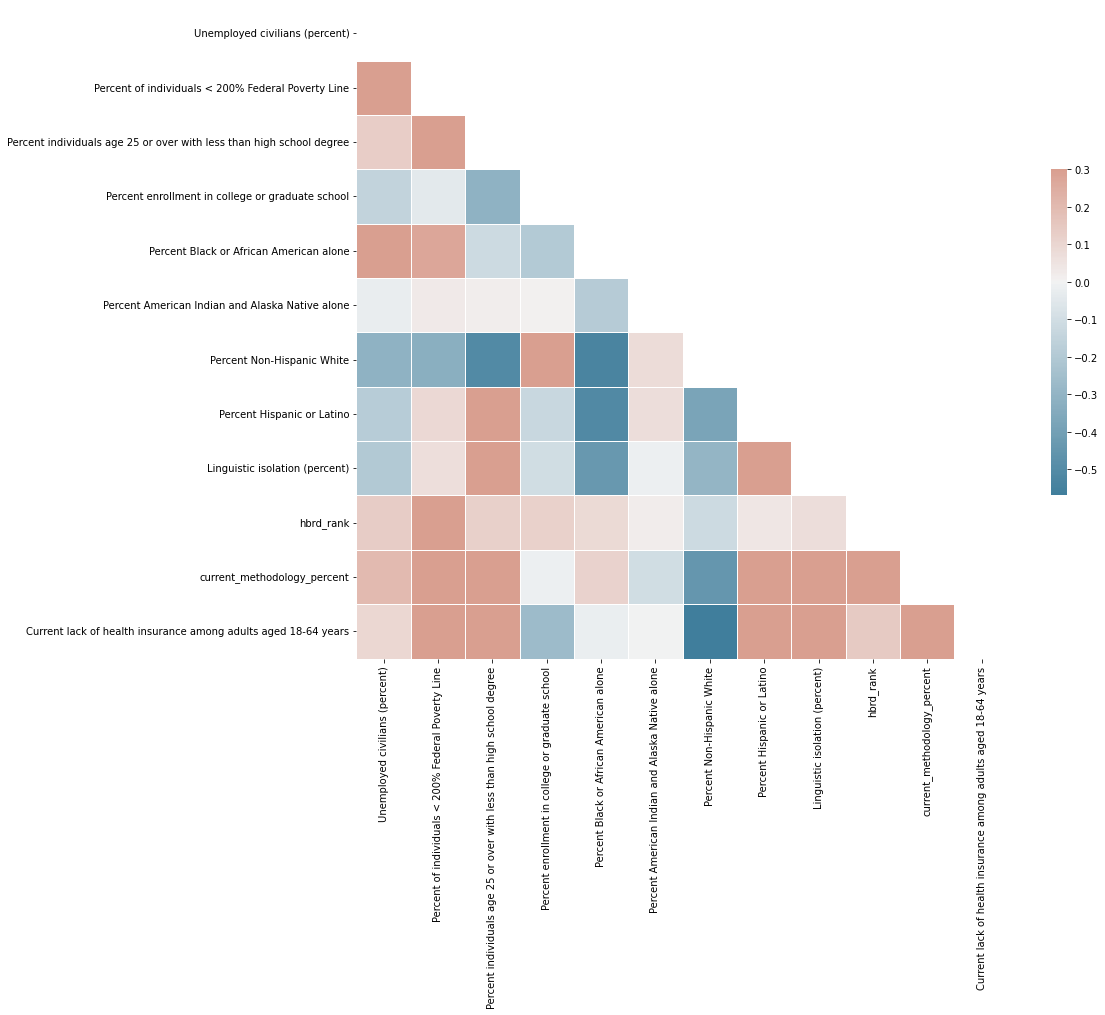

In [45]:
# Compute the correlation matrix
corr = combined_df_percent_cols_df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 12))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [46]:
combined_df.shape

(5726, 19)

In [47]:
import us

In [48]:
mapping = us.states.mapping('fips', 'abbr')

In [49]:
for idx, row in combined_df.iterrows():
    current_row = str(combined_df.loc[idx, 'state'])
    state = mapping.get(current_row, None)
    combined_df.loc[idx, 'state_name'] = state

/Users/sarahluw/justice-40-main/justice40-tool/data/data-pipeline/justifce-40-main-env/lib/python3.7/site-packages/pandas/core/indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
/Users/sarahluw/justice-40-main/justice40-tool/data/data-pipeline/justifce-40-main-env/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [50]:
combined_df.shape

(5726, 20)

In [51]:
combined_df.head()

,GEOID10_TRACT,state,Life expectancy (years),Unemployed civilians (percent),Percent of individuals < 200% Federal Poverty Line,Median value ($) of owner-occupied housing units,Percent individuals age 25 or over with less than high school degree,Percent enrollment in college or graduate school,Percent Black or African American alone,Percent American Indian and Alaska Native alone,Percent Non-Hispanic White,Linguistic isolation (percent),Current lack of health insurance among adults aged 18-64 years,Median household income in the past 12 months,Percent Hispanic or Latino,hbrd_rank,current_methodology_percent,current_summed_methodology,Urban Heuristic Flag,state_name
0,1005950700,01,73.1,14.901257,57.110946,137500,31.677019,1.619121,53.517423,0.000000,43.195266,0.000000,22.1,21607,0.000000,92.019231,36.0,218,1,AL
1,1011952100,01,78.5,10.035211,59.594680,66900,24.951267,5.647263,96.896770,0.000000,3.103230,3.145695,24.5,25343,0.000000,96.153846,35.0,222,0,AL
2,1015000200,01,75.6,7.220217,49.913941,77000,13.233533,4.289406,54.819277,1.118761,41.179002,1.862828,19.6,33720,6.196213,91.346154,39.0,475,1,AL
3,1015000300,01,67.1,13.260870,65.628944,51300,29.184038,6.350026,80.100968,0.631048,17.501052,0.000000,25.5,21175,1.766933,91.057692,42.0,488,1,AL
4,1015002101,01,72.9,10.682493,61.035565,153500,14.425163,68.001261,27.412083,0.000000,71.145176,0.000000,18.9,24543,0.510971,99.519231,50.0,483,1,AL


In [52]:
combined_df.state_name.value_counts()[:4]

CA    696
NY    434
TX    390
FL    359
Name: state_name, dtype: int64

In [53]:
# CA', 'NY', 'TX', 'FL....33.8 % of sample
target_states = list(combined_df.state_name.value_counts()[:4].keys())

In [54]:
# 1879 out of 5728
sum(list(combined_df.state_name.value_counts()[:4].values))

1879

In [55]:
combined_df.shape

(5726, 20)

In [56]:
# Remove college student-dominted tracts

In [57]:
combined_df.head()

,GEOID10_TRACT,state,Life expectancy (years),Unemployed civilians (percent),Percent of individuals < 200% Federal Poverty Line,Median value ($) of owner-occupied housing units,Percent individuals age 25 or over with less than high school degree,Percent enrollment in college or graduate school,Percent Black or African American alone,Percent American Indian and Alaska Native alone,Percent Non-Hispanic White,Linguistic isolation (percent),Current lack of health insurance among adults aged 18-64 years,Median household income in the past 12 months,Percent Hispanic or Latino,hbrd_rank,current_methodology_percent,current_summed_methodology,Urban Heuristic Flag,state_name
0,1005950700,01,73.1,14.901257,57.110946,137500,31.677019,1.619121,53.517423,0.000000,43.195266,0.000000,22.1,21607,0.000000,92.019231,36.0,218,1,AL
1,1011952100,01,78.5,10.035211,59.594680,66900,24.951267,5.647263,96.896770,0.000000,3.103230,3.145695,24.5,25343,0.000000,96.153846,35.0,222,0,AL
2,1015000200,01,75.6,7.220217,49.913941,77000,13.233533,4.289406,54.819277,1.118761,41.179002,1.862828,19.6,33720,6.196213,91.346154,39.0,475,1,AL
3,1015000300,01,67.1,13.260870,65.628944,51300,29.184038,6.350026,80.100968,0.631048,17.501052,0.000000,25.5,21175,1.766933,91.057692,42.0,488,1,AL
4,1015002101,01,72.9,10.682493,61.035565,153500,14.425163,68.001261,27.412083,0.000000,71.145176,0.000000,18.9,24543,0.510971,99.519231,50.0,483,1,AL


In [58]:
combined_df[(combined_df['Percent enrollment in college or graduate school' ] > 50)].shape

(119, 20)

In [59]:
combined_df = combined_df[~(combined_df['Percent enrollment in college or graduate school'] > 50)]

In [60]:
combined_df.shape

(5607, 20)

In [61]:
combined_df["GEOID10_TRACT"] = combined_df["GEOID10_TRACT"].astype(str)

In [105]:
comparison_tool_output = pd.read_csv("../data/comparison_outputs/Priority Tracts – Different geographic groupings.csv")

In [107]:
comparison_tool_output.iloc[5]

Country                                                                   USA
Analysis grouped by                                             GEOID10_STATE
GEOID10_STATE                                                             6.0
Geography name                                                     California
Definition L (communities) (percent tracts)                          0.376148
Definition L (communities) (percent population)                      0.375163
Climate Factor (Definition L) (percent tracts)                        0.03512
Climate Factor (Definition L) (percent population)                   0.033279
Energy Factor (Definition L) (percent tracts)                        0.238148
Energy Factor (Definition L) (percent population)                    0.230607
Transportation Factor (Definition L) (percent tracts)                 0.14073
Transportation Factor (Definition L) (percent population)            0.128957
Housing Factor (Definition L) (percent tracts)                  

In [62]:
# california only
combined_df_ca = combined_df[combined_df["state_name"].isin(target_states[:1])]

In [63]:
# combined_df_covriates_df = combined_df.select_dtypes(include=['float64'])

In [64]:
combined_df_ca = combined_df_ca[~(combined_df_ca[
    'GEOID10_TRACT'].isna())]

In [65]:
combined_df_ca.columns

Index(['GEOID10_TRACT', 'state', 'Life expectancy (years)',
       'Unemployed civilians (percent)',
       'Percent of individuals < 200% Federal Poverty Line',
       'Median value ($) of owner-occupied housing units',
       'Percent individuals age 25 or over with less than high school degree',
       'Percent enrollment in college or graduate school',
       'Percent Black or African American alone',
       'Percent American Indian and Alaska Native alone',
       'Percent Non-Hispanic White', 'Linguistic isolation (percent)',
       'Current lack of health insurance among adults aged 18-64 years',
       'Median household income in the past 12 months',
       'Percent Hispanic or Latino', 'hbrd_rank',
       'current_methodology_percent', 'current_summed_methodology',
       'Urban Heuristic Flag', 'state_name'],
      dtype='object')

In [66]:
combined_df_ca["GEOID10_TRACT"].nunique()

685

In [97]:
california = products.ACS(2019).from_place('Los Angeles, CA', level='tract',
                                        variables=['B01002H_001E'])

/Users/sarahluw/justice-40-main/justice40-tool/data/data-pipeline/justifce-40-main-env/lib/python3.7/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Matched: Los Angeles, CA to Los Angeles city within layer Incorporated Places


In [98]:
california

,GEOID,geometry,B01002H_001E,state,county,tract
0,06037296220,"POLYGON ((-13167749.020 3993777.050, -13167748...",42.6,06,037,296220
1,06037294520,"POLYGON ((-13165632.390 4000481.780, -13165603...",52.9,06,037,294520
2,06037294620,"POLYGON ((-13163943.340 4000298.270, -13163941...",38.9,06,037,294620
3,06037134201,"POLYGON ((-13202217.320 4058352.770, -13202183...",49.5,06,037,134201
4,06037113303,"POLYGON ((-13202321.070 4062417.020, -13202191...",47.9,06,037,113303
...,...,...,...,...,...,...
744,06037206020,"POLYGON ((-13162179.040 4036091.630, -13162176...",36.5,06,037,206020
745,06037199400,"POLYGON ((-13159612.340 4039453.040, -13159588...",38.6,06,037,199400
746,06037203720,"POLYGON ((-13158766.430 4035209.040, -13158719...",26.0,06,037,203720
747,06037183221,"POLYGON ((-13157571.300 4045808.090, -13157460...",47.4,06,037,183221


In [87]:
# source: https://www.census.gov/programs-surveys/geography/guidance/geo-identifiers.html
cols = ['state', 'county', 'tract']
california["GEOID10_TRACT"] = california[cols].apply(lambda row: ''.join(row.values.astype(str)), axis=1)

In [90]:
california["GEOID10_TRACT"] = california["GEOID10_TRACT"].apply(lambda x: x[1:])

In [93]:
intersection = list(set(combined_df_ca["GEOID10_TRACT"].values).intersection(set(california["GEOID10_TRACT"].values)))

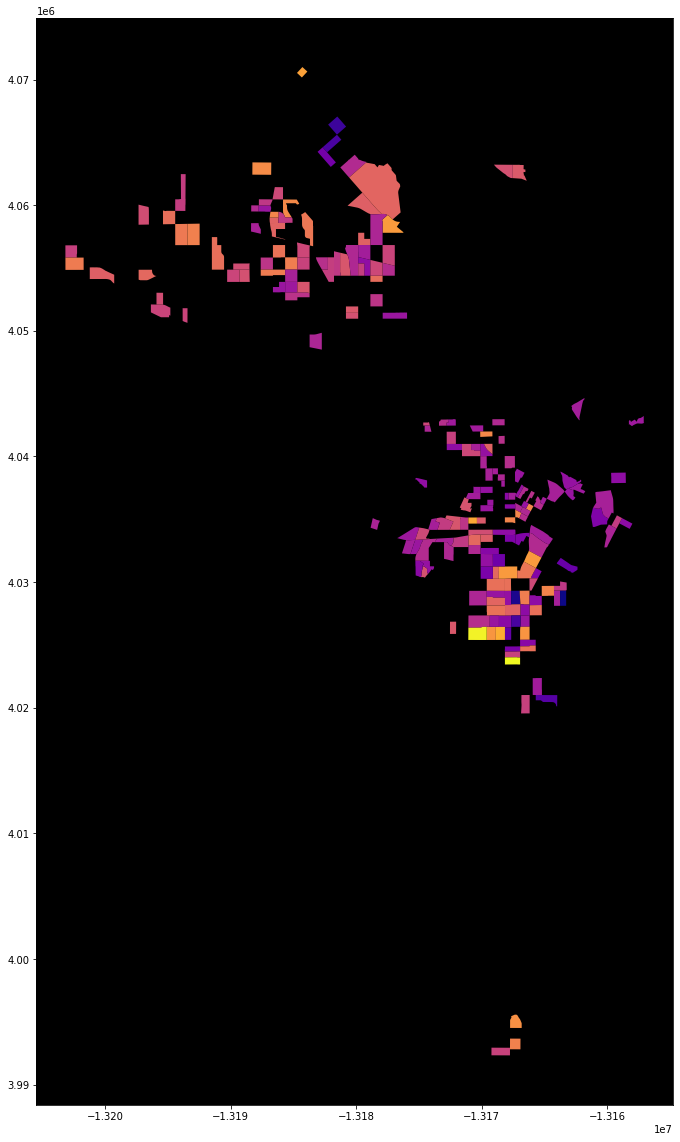

In [94]:
f, ax = plt.subplots(1,1,figsize=(20,20))
california[california.GEOID10_TRACT.isin(intersection
)].dropna(subset=['B01002H_001E'], axis=0).plot('B01002H_001E', ax=ax, cmap='plasma')
ax.set_facecolor('k')

In [99]:
dectest = products.Decennial2010()

la = dectest.from_county('Los Angeles, CA', 
                          level='tract', 
                          variables=['^P004'])

/Users/sarahluw/justice-40-main/justice40-tool/data/data-pipeline/justifce-40-main-env/lib/python3.7/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [104]:
len(intersection)

219

In [102]:
la["GEOID"] = la["GEOID"].apply(lambda x: x[1:])

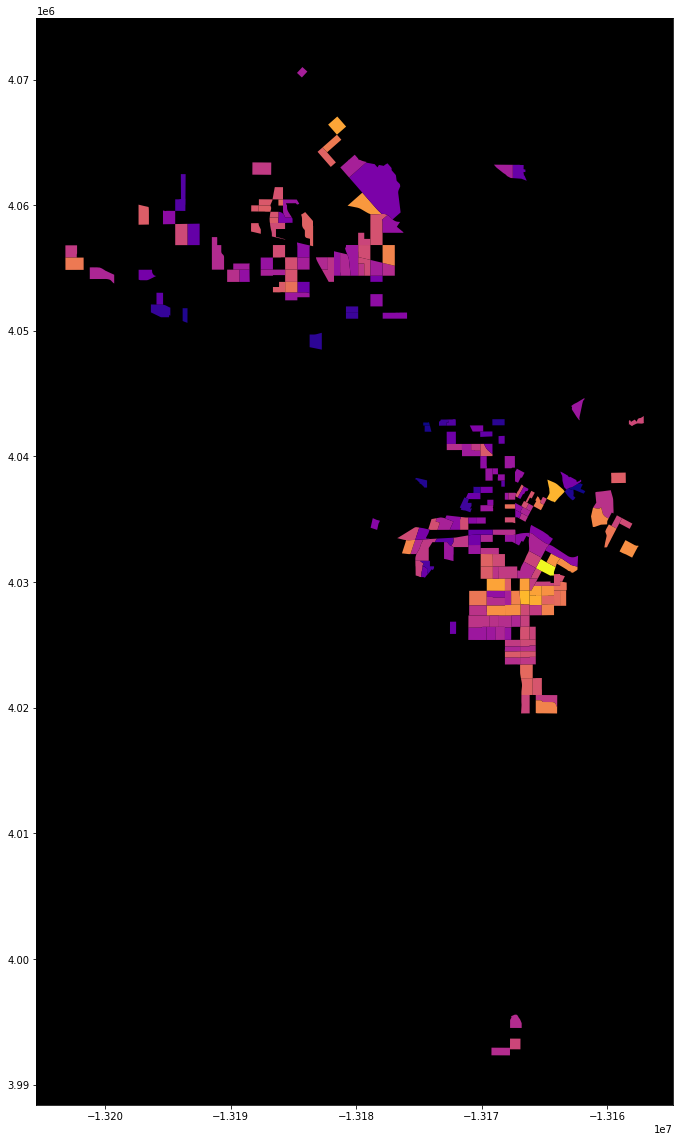

In [103]:
# And, making a pretty plot of the LatinX population of the 219 tracts in LA county
# Source: 2010 Decennial 
f, ax = plt.subplots(1,1,figsize=(20,20))
la[la.GEOID.isin(intersection
)].dropna(subset=['P004003'], axis=0).plot('P004003', ax=ax, cmap='plasma')
ax.set_facecolor('k')

### California

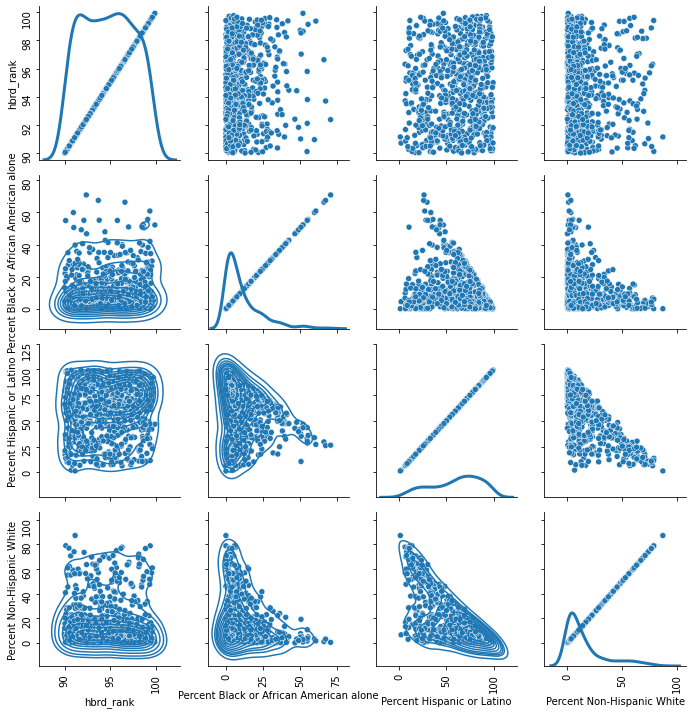

In [67]:
g = sns.PairGrid(combined_df_ca, vars=[
    'hbrd_rank',
    'Percent Black or African American alone',
    'Percent Hispanic or Latino',
    'Percent Non-Hispanic White', 
#     'Percent of tract that is HOLC Grade D',
], hue="state_name")
g.map(sns.scatterplot)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw=3, legend=True)
for ax in g.axes.flatten():
    ax.tick_params(rotation = 90)

In [57]:
# california
combined_df_ca.describe()[['hbrd_rank', 'Percent Non-Hispanic White', 
    'Percent Black or African American alone',   'Percent Hispanic or Latino']]

,hbrd_rank,Percent Non-Hispanic White,Percent Black or African American alone,Percent Hispanic or Latino
count,685.000000,685.000000,685.000000,685.000000
mean,94.747894,15.771612,11.090382,60.378188
std,2.791945,18.652813,12.304473,25.373697
min,90.002563,0.000000,0.000000,1.463861
25%,92.264804,2.438574,2.373129,41.301401
50%,94.757754,8.744881,6.508294,64.634664
75%,97.064855,20.189934,15.542137,80.677638
max,99.923097,87.282708,70.925427,99.442231


In [60]:
# new york only
combined_df_temp_ny = combined_df[combined_df["state_name"].isin(target_states[1:2])]

In [61]:
# NY
combined_df_temp_ny.describe()[['hbrd_rank', 'Percent Non-Hispanic White', 
    'Percent Black or African American alone',   'Percent Hispanic or Latino']]

,hbrd_rank,Percent Non-Hispanic White,Percent Black or African American alone,Percent Hispanic or Latino
count,432.000000,432.000000,432.000000,432.000000
mean,94.930511,21.411171,31.910302,36.308587
std,2.887202,28.182290,27.725260,26.236893
min,90.019317,0.000000,0.000000,0.152568
25%,92.468877,2.077964,5.589505,11.921255
50%,94.859412,7.725998,25.861088,30.061539
75%,97.408242,30.196248,51.836578,61.084394
max,100.000000,99.711816,96.529499,92.430905


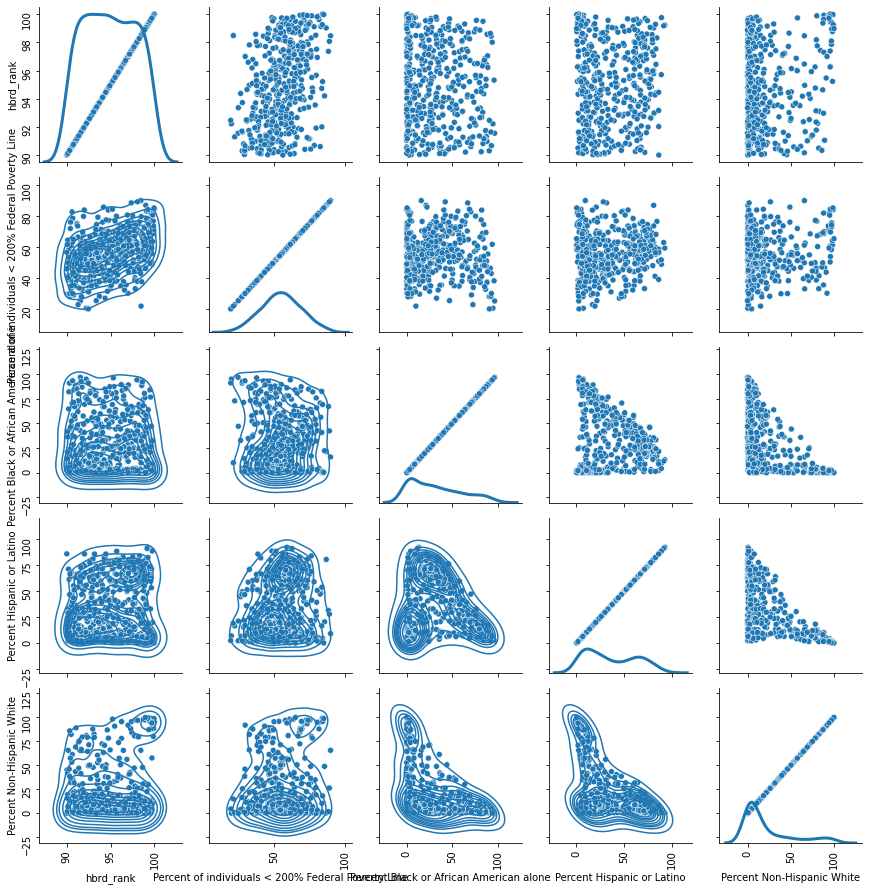

In [62]:
g = sns.PairGrid(combined_df_temp_ny, vars=[
    'hbrd_rank',
    'Percent of individuals < 200% Federal Poverty Line',
    'Percent Black or African American alone',
    'Percent Hispanic or Latino',
    'Percent Non-Hispanic White', 
#  'Percent of tract that is HOLC Grade D',    
], hue="state_name")
g.map(sns.scatterplot)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw=3, legend=True)
for ax in g.axes.flatten():
    ax.tick_params(rotation = 90)

In [63]:
# texas  only
combined_df_tx = combined_df[combined_df["state_name"].isin(target_states[2:3])]

In [64]:
# Texas
combined_df_tx.describe()[['hbrd_rank', 'Percent Non-Hispanic White', 
    'Percent Black or African American alone',   'Percent Hispanic or Latino']]

,hbrd_rank,Percent Non-Hispanic White,Percent Black or African American alone,Percent Hispanic or Latino
count,374.000000,374.000000,374.000000,374.000000
mean,94.540610,19.308000,24.301579,51.913930
std,2.678178,19.019545,23.495303,27.389138
min,90.006447,0.000000,0.000000,0.000000
25%,92.203954,4.875476,5.408347,28.650159
50%,94.487427,12.200307,16.370207,51.144643
75%,96.813884,29.568056,38.021127,74.862463
max,99.699119,89.951983,94.683544,100.000000


In [65]:
# florida  only
combined_df_fl = combined_df[combined_df["state_name"].isin(target_states[3:4])]

In [66]:
# Texas
combined_df_fl.describe()[['hbrd_rank', 'Percent Non-Hispanic White', 
    'Percent Black or African American alone',   'Percent Hispanic or Latino']]

,hbrd_rank,Percent Non-Hispanic White,Percent Black or African American alone,Percent Hispanic or Latino
count,351.000000,351.000000,351.000000,351.000000
mean,94.843405,17.673712,37.260894,43.807197
std,2.878474,19.049916,31.325189,33.267694
min,90.010040,0.000000,0.000000,0.352338
25%,92.356928,3.573174,6.644762,13.770096
50%,94.779116,9.288316,30.750868,35.026944
75%,97.326807,25.677429,65.324654,73.540553
max,99.949799,91.065662,98.522167,98.819109


### After applying the CalEnvironScreen's methodology for Housing Burden Rank (CHBR), we identify some global trends across all of the tracts in this sample where greater than 90 percent of owned and rented households are considered burdened

 1. Poverty is most correlated with CHBR and current methodology (referencing, percent of individuals < 200% Federal Poverty Line)
 2. The current methodology is negatively correlated with the percentage of non-Hispanic white populations across all tracts
 3. CHBR is more "race-neutral" than the current methodology in the sense that there is little to no relationship with racial self-identification across all states. However, if one looks at descriptive statistics state-by-state, there is a clear pattern of stratification in Latin-X communities. Focusing on just the most representative states (Florida, Texas, New York, and California - which comprise 33.8 % of the sample considered burdened we observe the following:
 * In Califonia the median percentage of the tract that identifies as Latin-X is ~ 64.6 %. Moreover, the sample for California represents 506, 990 households in aggregate.
 
 * In addition, Texas and Florida predominantly represent tracts comprised of LatinX (51% and 35% respectively, and  271, 370, and 295, 318 households, respectively).
 4. CHBR is less positively correlated than the current methodology as it pertains to high school education
 5. In this sample of New York state's 191 the median percent of individuals < 200% Federal Poverty Line, of a tract that is ~55.2% (n = 432 tracts). Moreover, in New York - where all tracts are considered "urban" by the definition L criterion - the median percent of the population that identifies as African American is 25.86%.
 6. Similarly to (5), in Florida (n = 351, with one tract considered "rural"), we observe that the median percent of the population that identifies as African American is 30.89%. 

In [72]:
combined_df.columns

Index(['GEOID10_TRACT', 'state', 'Life expectancy (years)',
       'Unemployed civilians (percent)',
       'Percent of individuals < 200% Federal Poverty Line',
       'Median value ($) of owner-occupied housing units',
       'Percent individuals age 25 or over with less than high school degree',
       'Percent enrollment in college or graduate school',
       'Percent Black or African American alone',
       'Percent American Indian and Alaska Native alone',
       'Percent Non-Hispanic White', 'Linguistic isolation (percent)',
       'Current lack of health insurance among adults aged 18-64 years',
       'Median household income in the past 12 months',
       'Percent Hispanic or Latino', 'hbrd_rank',
       'current_methodology_percent', 'current_summed_methodology',
       'Urban Heuristic Flag', 'state_name'],
      dtype='object')

In [86]:
grouped_stats = combined_df.groupby(["state_name", "Urban Heuristic Flag"]).agg({
       'GEOID10_TRACT': 'nunique',
       'Percent of individuals < 200% Federal Poverty Line': [np.median, 'nunique', np.std],
       'Median value ($) of owner-occupied housing units': [np.median, 'nunique', np.std],
       'Percent individuals age 25 or over with less than high school degree': [np.median, 'nunique', np.std],
       'Percent enrollment in college or graduate school': [np.median, 'nunique', np.std],
#        'Hispanic or Latino': [np.median, 'nunique'. np.std],
       'Percent Black or African American alone': [np.median, 'nunique', np.std],
       'Percent American Indian and Alaska Native alone': [np.median, 'nunique', np.std],
       'Percent Non-Hispanic White': [np.median, 'nunique', np.std], 
     'Linguistic isolation (percent)': [np.median, 'nunique', np.std],
#        'Percent of tract that is HOLC Grade D': [np.median, 'nunique', np.std],
       'Current lack of health insurance among adults aged 18-64 years': [np.median, 'nunique', np.std],
       'Median household income in the past 12 months': [np.median, 'nunique', np.std],
       'Percent Hispanic or Latino': [np.median, 'nunique', np.std],
      'hbrd_rank': [np.median, 'nunique', np.std],
      'current_methodology_percent': [np.median, 'nunique', np.std],
      'current_summed_methodology': [np.median, 'nunique', np.std, np.sum]

}).reset_index()

In [87]:
target_state_groupeds_df = grouped_stats[grouped_stats.state_name.isin(target_states)]

In [88]:
target_state_groupeds_df.columns = [' '.join(col).strip() for col in target_state_groupeds_df.columns.values]

In [99]:
target_state_groupeds_df.columns

Index(['state_name', 'Urban Heuristic Flag', 'GEOID10_TRACT nunique',
       'Percent of individuals < 200% Federal Poverty Line median',
       'Percent of individuals < 200% Federal Poverty Line nunique',
       'Percent of individuals < 200% Federal Poverty Line std',
       'Median value ($) of owner-occupied housing units median',
       'Median value ($) of owner-occupied housing units nunique',
       'Median value ($) of owner-occupied housing units std',
       'Percent individuals age 25 or over with less than high school degree median',
       'Percent individuals age 25 or over with less than high school degree nunique',
       'Percent individuals age 25 or over with less than high school degree std',
       'Percent enrollment in college or graduate school median',
       'Percent enrollment in college or graduate school nunique',
       'Percent enrollment in college or graduate school std',
       'Percent Black or African American alone median',
       'Percent Black o

In [100]:
target_state_groupeds_df[['GEOID10_TRACT nunique','state_name', 'Percent Black or African American alone median']]

,GEOID10_TRACT nunique,state_name,Percent Black or African American alone median
6,685,CA,6.508294
12,1,FL,22.120285
13,350,FL,30.896102
44,432,NY,25.861088
57,3,TX,0.084998
58,371,TX,16.522423


In [93]:
target_state_groupeds_df.to_csv("top_4_states_12202021.csv")

In [78]:
# ca
506752 + 238

506990

In [91]:
# tx
270057 + 1313

271370

In [92]:
# fl
295080 + 238

295318